## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.

I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features

This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

*work in progress*

![](https://torontoseoulcialite.com/wp-content/uploads/2016/02/zimbiocom.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

/Users/sam/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


importing and setting up altair

In [3]:
import altair as alt
from  altair.vega import v3
from IPython.display import HTML
import json
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

In [5]:
feature_path = '../../features/lanl-features-from-Andrew/'
os.listdir(feature_path)

['submission_1.csv',
 'train_features_denoised.csv',
 'test_features_denoised.csv',
 'test_features.csv',
 'y.csv',
 'train_features.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [11]:
train_features = pd.read_csv(feature_path + 'train_features.csv')
test_features = pd.read_csv(feature_path + 'test_features.csv')
train_features_denoised = pd.read_csv(feature_path + 'train_features_denoised.csv')
test_features_denoised = pd.read_csv(feature_path + 'test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv(feature_path + 'y.csv')

In [12]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

In [15]:
X.head()

,Hann_window_mean_150,Hann_window_mean_1500,Hann_window_mean_15000,Hann_window_mean_50,Hilbert_mean,abs_energy,abs_max,abs_max_roll_mean_10,abs_max_roll_mean_100,abs_max_roll_mean_1000,...,time_rev_asym_stat_1_denoised,time_rev_asym_stat_10_denoised,time_rev_asym_stat_100_denoised,time_rev_asym_stat_1000_denoised,time_rev_asym_stat_10000_denoised,time_rev_asym_stat_5_denoised,time_rev_asym_stat_50_denoised,time_rev_asym_stat_500_denoised,trend_denoised,var_larger_than_std_dev_denoised
0,4.883327023570954,4.876660693097298,4.809075953159121,4.883859523420638,7.027028035412704,7481351.0,104.0,68.500000000000000,10.039999999999999,5.629000000000000,...,-0.096420407246901,-24.507658220827970,3.706442323830551,1.413534184174831,0.471447345824418,-6.521118219461393,-0.009140143692533,2.522993798144944,-0.000000060056403,True
1,4.725049132238183,4.718420573548181,4.653152157320807,4.725527100974546,7.380382529587168,9861777.0,181.0,145.099999999999994,16.670000000000002,5.667000000000002,...,0.258199532798016,88.924023421070942,143.980043802316686,7.359462725006689,-2.108296571555000,84.043278984183502,68.351270883398328,6.802377071091023,-0.000000020051138,True
2,4.905511258078014,4.898920772317807,4.832203777557303,4.906040032534657,8.016930170432310,10892549.0,140.0,94.799999999999997,12.380000000000001,5.957000000000002,...,-0.615191595512900,-24.766723941285051,65.447497488503188,0.486344666576969,6.692607147215793,-37.209306572942772,11.370507392062022,40.075131250635721,0.000000086074548,True
3,4.901427864908424,4.894639042521090,4.827671244276916,4.901984819425586,7.606849953983147,10792492.0,199.0,136.599999999999994,18.260000000000002,5.858000000000000,...,1.888609274809342,214.061271017309423,235.203521470197302,-0.909736517939260,4.128007149771127,147.369930250765037,-82.615385161359043,21.555171209747233,-0.000000012875785,True
4,4.908115126624049,4.901854958025392,4.836297018529053,4.908528375436501,7.895402664474322,11610208.0,145.0,107.599999999999994,14.410000000000000,6.077999999999999,...,-0.941679270691838,8.955586639683442,59.356235470642254,3.132654224243285,0.467576902184649,17.314863577612133,56.868139445440292,-31.466588602536980,-0.000000074737843,True


We have almost 2000 features here!

In [7]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Training function

Training function is in the hidden cell below

In [27]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        time_start = time.time()
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params, loss_function='MAE')
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        print('Loop time: {} sec'.format(time.time()-time_start), end='\n\n')
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

## First model

Fold 0 started at Wed May  1 23:35:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's l1: 1.36219	valid_1's l1: 2.09824
Loop time: 12.85587215423584 sec
Fold 1 started at Wed May  1 23:35:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's l1: 1.26662	valid_1's l1: 2.01311
Loop time: 12.824237823486328 sec
Fold 2 started at Wed May  1 23:35:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's l1: 1.45644	valid_1's l1: 2.14801
Loop time: 10.374923944473267 sec
Fold 3 started at Wed May  1 23:35:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[386]	training's l1: 1.55146	valid_1's l1: 1.94593
Loop time: 10.346670150756836 sec
Fold 4 started at Wed May  1 23:35:56 2019
Training until validation scores don't improve for 200

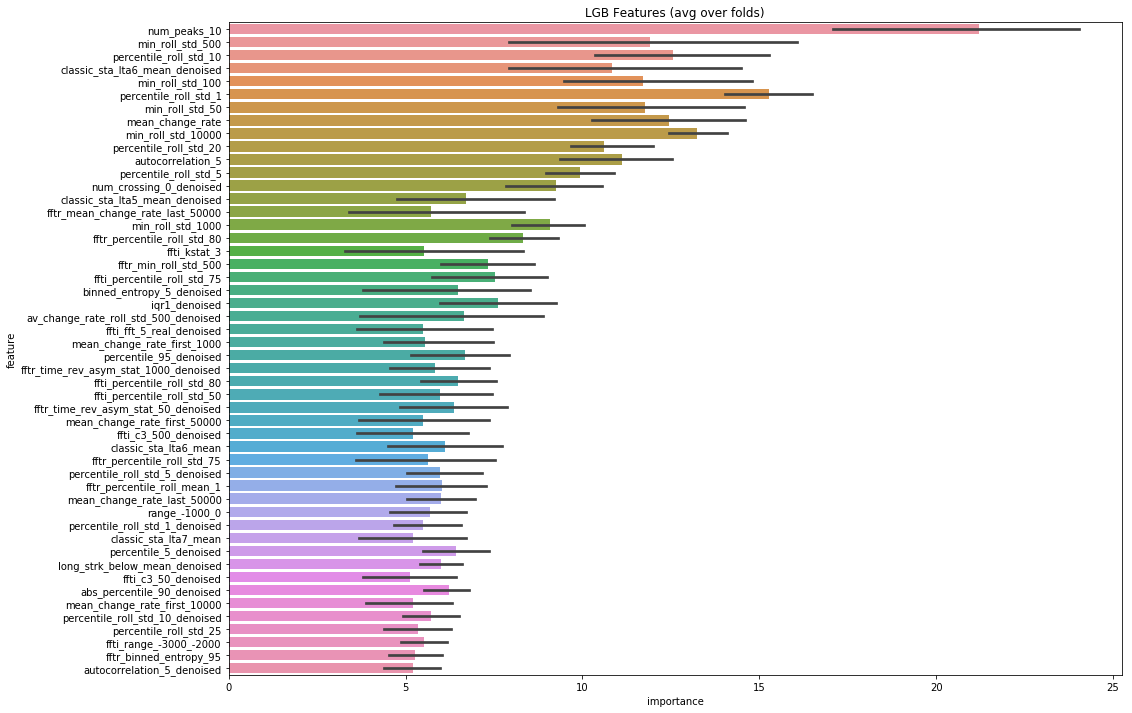

In [26]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [19]:
submission = pd.read_csv('../../data/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  3.896327829703170
seg_0012b5  4.715197143682085
seg_00184e  5.370022991067648
seg_003339  8.561374762827588
seg_0042cc  6.983173796214087


In [10]:
sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [29]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [12]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist


CPU times: user 3min 34s, sys: 248 ms, total: 3min 34s
Wall time: 55.2 s


Fold 0 started at Wed May  1 23:39:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[641]	training's l1: 1.32557	valid_1's l1: 2.09949
Loop time: 9.975237846374512 sec

Fold 1 started at Wed May  1 23:39:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[962]	training's l1: 1.09934	valid_1's l1: 2.01123
Loop time: 13.760859727859497 sec

Fold 2 started at Wed May  1 23:40:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[448]	training's l1: 1.4957	valid_1's l1: 2.15614
Loop time: 7.724501848220825 sec

Fold 3 started at Wed May  1 23:40:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[453]	training's l1: 1.52706	valid_1's l1: 1.94339
Loop time: 6.2883141040802 sec

Fold 4 started at Wed May  1 23:40:21 2019
Training until validation scores don't improve for 200 

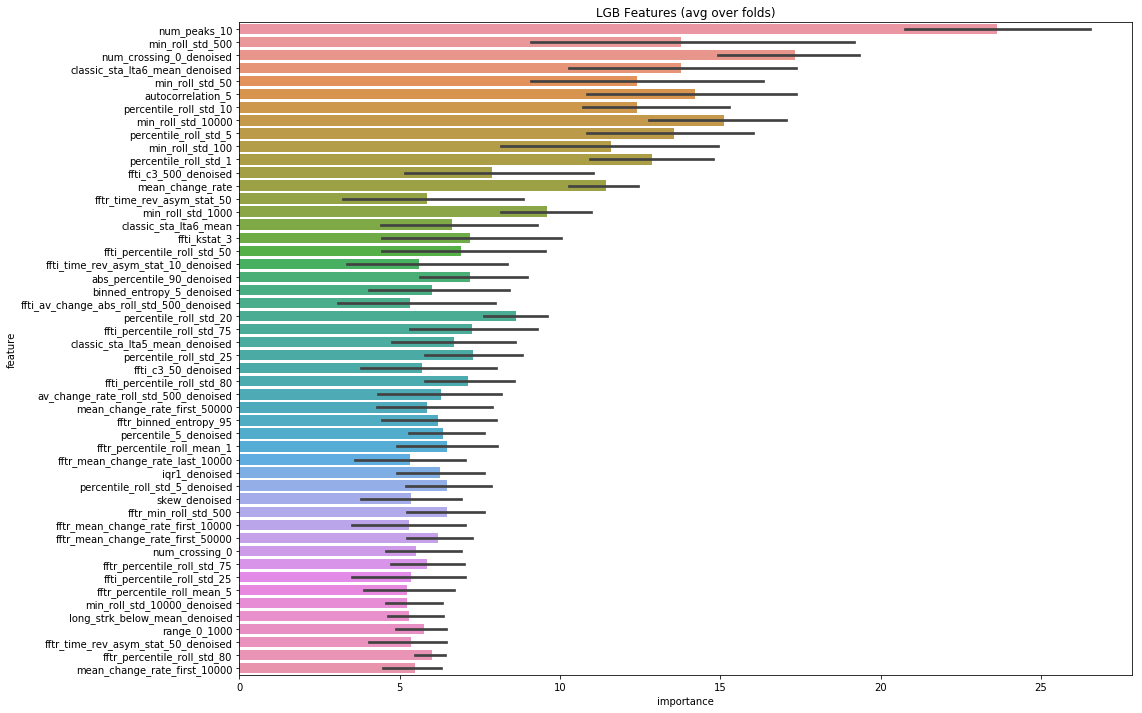

In [31]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X_train_scaled, X_test_scaled, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [14]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [32]:
top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
        verbose=10000, early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's l1: 1.81966	valid_1's l1: 2.03136


In [33]:
eli5.show_weights(perm, top=50, feature_names=top_columns)

Weight,Feature
0.0377 ± 0.0066,num_crossing_0_denoised
0.0204 ± 0.0007,num_peaks_10
0.0164 ± 0.0017,abs_percentile_90_denoised
0.0142 ± 0.0037,percentile_roll_std_10
0.0136 ± 0.0010,percentile_roll_std_5
0.0132 ± 0.0046,percentile_95_denoised
0.0130 ± 0.0019,percentile_5_denoised
0.0126 ± 0.0011,percentile_roll_std_1
0.0115 ± 0.0021,min_roll_std_10000
0.0083 ± 0.0017,min_roll_std_100


Fold 0 started at Wed May  1 23:47:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[494]	training's l1: 1.81749	valid_1's l1: 2.12893
Loop time: 0.602910041809082 sec

Fold 1 started at Wed May  1 23:47:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1122]	training's l1: 1.62082	valid_1's l1: 2.03019
Loop time: 1.165510892868042 sec

Fold 2 started at Wed May  1 23:47:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[624]	training's l1: 1.7587	valid_1's l1: 2.15226
Loop time: 0.663236141204834 sec

Fold 3 started at Wed May  1 23:47:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[540]	training's l1: 1.83491	valid_1's l1: 1.94363
Loop time: 0.6739368438720703 sec

Fold 4 started at Wed May  1 23:47:15 2019
Training until validation scores don't improve for 2

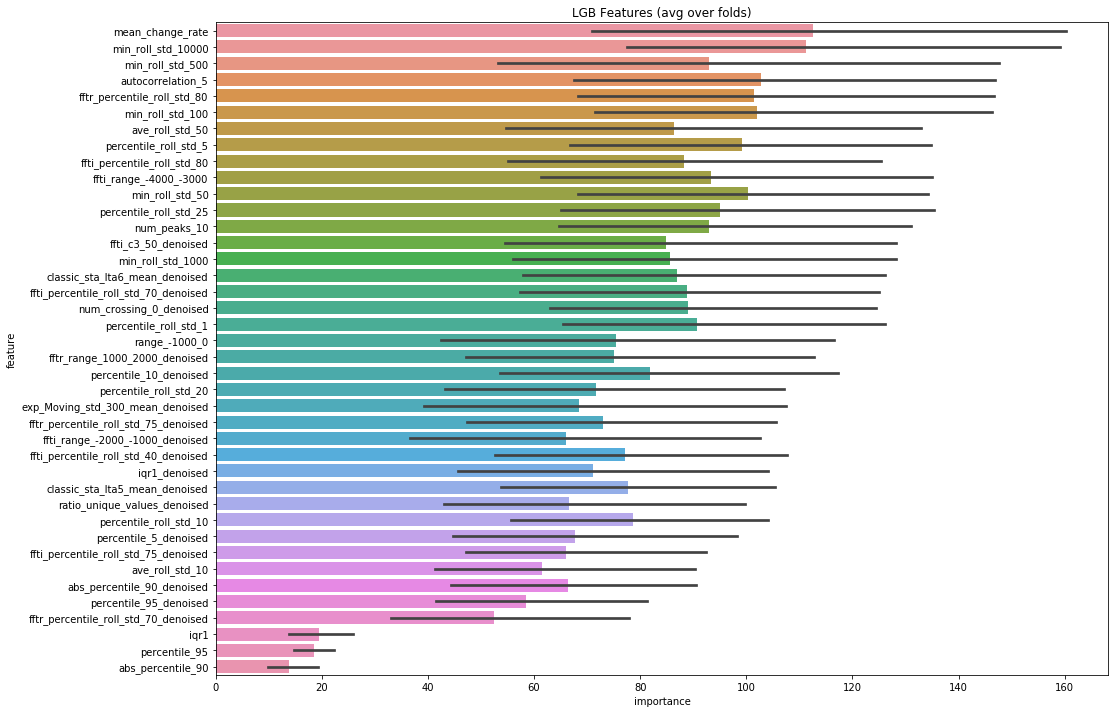

In [34]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:40]
oof_lgb, prediction_lgb, feature_importance = train_model(X[top_features], X_test[top_features], y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [35]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [19]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
         }

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [20]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in range(5, 105, 5):
#     print(i)
#     s1 = SelectPercentile(f_classif, percentile=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(scores))
    
#     s2 = SelectPercentile(mutual_info_classif, percentile=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [36]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [37]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [23]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in np.arange(10, 1958, 100):
#     print(i)
#     s1 = SelectKBest(f_classif, k=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(scores))
    
#     s2 = SelectKBest(mutual_info_classif, k=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [38]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [39]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 0 started at Wed May  1 23:54:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's l1: 1.42745	valid_1's l1: 2.08622
Loop time: 4.635605812072754 sec

Fold 1 started at Wed May  1 23:54:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[887]	training's l1: 1.18116	valid_1's l1: 1.99087
Loop time: 5.408035755157471 sec

Fold 2 started at Wed May  1 23:54:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[557]	training's l1: 1.41416	valid_1's l1: 2.15116
Loop time: 4.191439151763916 sec

Fold 3 started at Wed May  1 23:54:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[456]	training's l1: 1.54159	valid_1's l1: 1.9428
Loop time: 5.39163613319397 sec

Fold 4 started at Wed May  1 23:54:21 2019
Training until validation scores don't improve for 200 

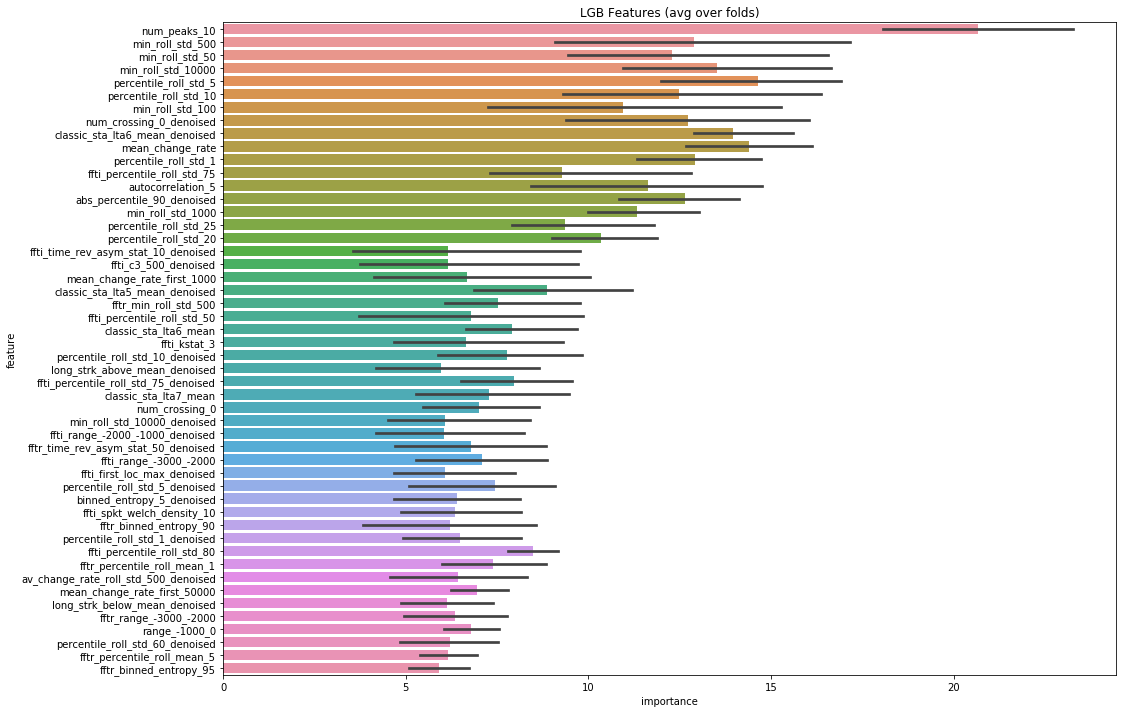

In [40]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
oof_lgb, prediction_lgb, feature_importance = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [44]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_no_corr.csv')

### RFE


**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [28]:
# %%time
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [45]:
scores_dict = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811], 'n_features': [10, 110, 210]}

In [46]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by RFE vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [47]:
%%time
rfr = RandomForestRegressor()

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
oof_rfr, prediction_rfr, scores_rfr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=rfr)
print(scores_rfr)

Fold 0 started at Wed May  1 23:56:14 2019
Fold 0. MAE: 2.1510.

Loop time: 37.54701328277588 sec

Fold 1 started at Wed May  1 23:56:51 2019
Fold 1. MAE: 2.0973.

Loop time: 39.79900503158569 sec

Fold 2 started at Wed May  1 23:57:31 2019
Fold 2. MAE: 2.1866.

Loop time: 39.30531024932861 sec

Fold 3 started at Wed May  1 23:58:10 2019
Fold 3. MAE: 1.9949.

Loop time: 36.31731128692627 sec

Fold 4 started at Wed May  1 23:58:47 2019
Fold 4. MAE: 2.1109.

Loop time: 34.361693143844604 sec

CV mean score: 2.1081, std: 0.0647.
[2.151001775817705, 2.0972592686337053, 2.1865923389588815, 1.994850819701977, 2.1108547293857156]
CPU times: user 3min 5s, sys: 1.32 s, total: 3min 6s
Wall time: 3min 7s


In [48]:
%%time
linreg = linear_model.LinearRegression(normalize=True, copy_X=True, n_jobs=-1)

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
# rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
oof_linreg, prediction_linreg, scores_linreg = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=linreg)
# print(scores_linreg)

Fold 0 started at Wed May  1 23:59:21 2019
Fold 0. MAE: 39.2807.

Loop time: 3.3602898120880127 sec

Fold 1 started at Wed May  1 23:59:24 2019
Fold 1. MAE: 597089.7138.

Loop time: 2.975511074066162 sec

Fold 2 started at Wed May  1 23:59:27 2019
Fold 2. MAE: 49.4758.

Loop time: 3.1718852519989014 sec

Fold 3 started at Wed May  1 23:59:31 2019
Fold 3. MAE: 231.4010.

Loop time: 2.991313934326172 sec

Fold 4 started at Wed May  1 23:59:34 2019
Fold 4. MAE: 1580.4181.

Loop time: 3.121718168258667 sec

CV mean score: 119798.0579, std: 238646.5203.
CPU times: user 23.4 s, sys: 1.9 s, total: 25.3 s
Wall time: 15.6 s


In [49]:
%%time
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
oof_ridge, prediction_ridge, scores_ridge = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=ridge)
# print(scores_ridge)

Best score: -2.148000987584754
Best parameters: {'alpha': 1.0}
Fold 0 started at Wed May  1 23:59:44 2019
Fold 0. MAE: 2.1765.

Loop time: 0.687086820602417 sec

Fold 1 started at Wed May  1 23:59:44 2019
Fold 1. MAE: 2.1246.

Loop time: 0.6791260242462158 sec

Fold 2 started at Wed May  1 23:59:45 2019
Fold 2. MAE: 2.2160.

Loop time: 0.6947410106658936 sec

Fold 3 started at Wed May  1 23:59:46 2019
Fold 3. MAE: 2.0088.

Loop time: 0.6659419536590576 sec

Fold 4 started at Wed May  1 23:59:46 2019
Fold 4. MAE: 2.2141.

Loop time: 0.6379148960113525 sec

CV mean score: 2.1480, std: 0.0771.
CPU times: user 4.69 s, sys: 1.1 s, total: 5.79 s
Wall time: 10.2 s


In [50]:
%%time
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [50, 100]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
oof_knn, prediction_knn, scores_knn = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=knn)

Best score: -2.386296024679084
Best parameters: {'n_neighbors': 100}
Fold 0 started at Wed May  1 23:59:54 2019
Fold 0. MAE: 2.4430.

Loop time: 2.110283136367798 sec

Fold 1 started at Wed May  1 23:59:56 2019
Fold 1. MAE: 2.3574.

Loop time: 2.0899569988250732 sec

Fold 2 started at Wed May  1 23:59:58 2019
Fold 2. MAE: 2.4659.

Loop time: 2.0893819332122803 sec

Fold 3 started at Thu May  2 00:00:00 2019
Fold 3. MAE: 2.2854.

Loop time: 2.3072988986968994 sec

Fold 4 started at Thu May  2 00:00:02 2019
Fold 4. MAE: 2.3797.

Loop time: 2.0156097412109375 sec

CV mean score: 2.3863, std: 0.0642.
CPU times: user 10.2 s, sys: 1.06 s, total: 11.3 s
Wall time: 17.4 s


In [51]:
%%time
lasso = linear_model.Lasso(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
lasso = linear_model.Lasso(**grid_search.best_params_, normalize=True)
oof_lasso, prediction_lasso, scores_lasso = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=lasso)

Best score: -3.048578606466069
Best parameters: {'alpha': 0.1}
Fold 0 started at Thu May  2 00:00:09 2019
Fold 0. MAE: 3.1293.

Loop time: 0.7358560562133789 sec

Fold 1 started at Thu May  2 00:00:09 2019
Fold 1. MAE: 3.1061.

Loop time: 0.7999207973480225 sec

Fold 2 started at Thu May  2 00:00:10 2019
Fold 2. MAE: 3.0267.

Loop time: 0.7511711120605469 sec

Fold 3 started at Thu May  2 00:00:11 2019
Fold 3. MAE: 2.9735.

Loop time: 0.7150862216949463 sec

Fold 4 started at Thu May  2 00:00:12 2019
Fold 4. MAE: 3.0073.

Loop time: 0.7043540477752686 sec

CV mean score: 3.0486, std: 0.0594.
CPU times: user 3.35 s, sys: 1.13 s, total: 4.48 s
Wall time: 7.95 s


In [52]:
%%time
etr = ExtraTreesRegressor()

parameter_grid = {'n_estimators': [500, 1000],
                  'max_depth': [5, 10, 20]
                 }

grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
etr = ExtraTreesRegressor(**grid_search.best_params_)
oof_etr, prediction_etr, scores_etr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=etr)

KeyboardInterrupt: 

In [ ]:
%%time
huber = linear_model.HuberRegressor()

parameter_grid = {'epsilon ': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(huber, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
huber = linear_model.huber(**grid_search.best_params_)
oof_huber, prediction_huber, scores_huber = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=huber)

In [ ]:
%%time
adr = AdaBoostRegressor()

parameter_grid = {'n_estimators': [10, 50, 100, 500],
                 }

grid_search = GridSearchCV(adr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
adr = AdaBoostRegressor(**grid_search.best_params_)
oof_adr, prediction_adr, scores_adr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=adr)

In [ ]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestRegressor': scores_rfr})
scores_df['ExtraTreesRegressor'] = scores_etr
scores_df['AdaBoostRegressor'] = scores_adr
scores_df['KNN'] = scores_knn
scores_df['LinearRegression'] = scores_linreg
scores_df['Ridge'] = scores_ridge
scores_df['Lasso'] = scores_lasso
scores_df['Huber'] = scores_huber

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);